# S4E4 Regression with an Abalone Dataset

## Imports and Reading Data

In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [27]:
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id')

# original data from UCI Machine Learning Repository
original_data = pd.read_csv('data/abalone.data')
# give the columns names  
original_data.columns = train.columns

# combine two dataset into a new one 
new_train = pd.concat([train, original_data], axis=0)
# rename the index column into id 
new_train.index.name = 'id'

# save the new dataset
new_train.to_csv('data/new_train.csv')

new_train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


## Feature Explanation

The dataset contains 9 features and 1 target variable. The features are as follows 
- Sex: M, F, and I (infant) (Nominal)
- Length: Longest shell measurement (mm)
- Diameter: Perpendicular to length (mm)
- Height: With meat in shell (mm)
- Whole weight: Whole abalone (g)
- Shucked weight: Weight of meat (g)
- Viscera weight: Gut weight (after bleeding) (g)
- Shell weight: After being dried (g)

All but the first feature are continuous. We are given these information to predict the number of rings in the abalone. The number of rings is a proxy for the age of the abalone. 

- Rings: +1.5 gives the age in years


This competition is evaluated using **Root Mean Squared Logarithmic Error** where 

$$
\sqrt{\frac1n\sum_{i=1}^{n}\left(\ln(1+\hat y_i)-\ln(1+y_i)\right)^2}.
$$



## Basic EDA

In [28]:
X = new_train.drop('Rings', axis=1) 
y = new_train['Rings']
X_test = test 

In [29]:
X.describe()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
count,94791.000000,94791.000000,94791.000000,94791.000000,94791.000000,94791.000000,94791.000000
mean,0.517403,0.401953,0.135643,0.790788,0.341598,0.169915,0.226469
std,0.118308,0.098088,0.038193,0.459233,0.205268,0.101334,0.130640
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.445000,0.345000,0.110000,0.419500,0.177500,0.086500,0.120000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000
75%,0.600000,0.470000,0.160000,1.072500,0.464500,0.233000,0.305000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [30]:
y.describe()

count    94791.000000
mean         9.707177
std          3.178674
min          1.000000
25%          8.000000
50%          9.000000
75%         11.000000
max         29.000000
Name: Rings, dtype: float64

In [31]:
# check null values
print("===Check for missing values===")
print(X.isnull().sum()) 
print(X_test.isnull().sum())
# check duplicated values
print("===Check for duplicated values===")
print(X.duplicated().sum())
print(X_test.duplicated().sum())

===Check for missing values===
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64
===Check for duplicated values===
285
0


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Whole weight'}>,
        <Axes: title={'center': 'Whole weight.1'}>,
        <Axes: title={'center': 'Whole weight.2'}>],
       [<Axes: title={'center': 'Shell weight'}>, <Axes: >, <Axes: >]],
      dtype=object)

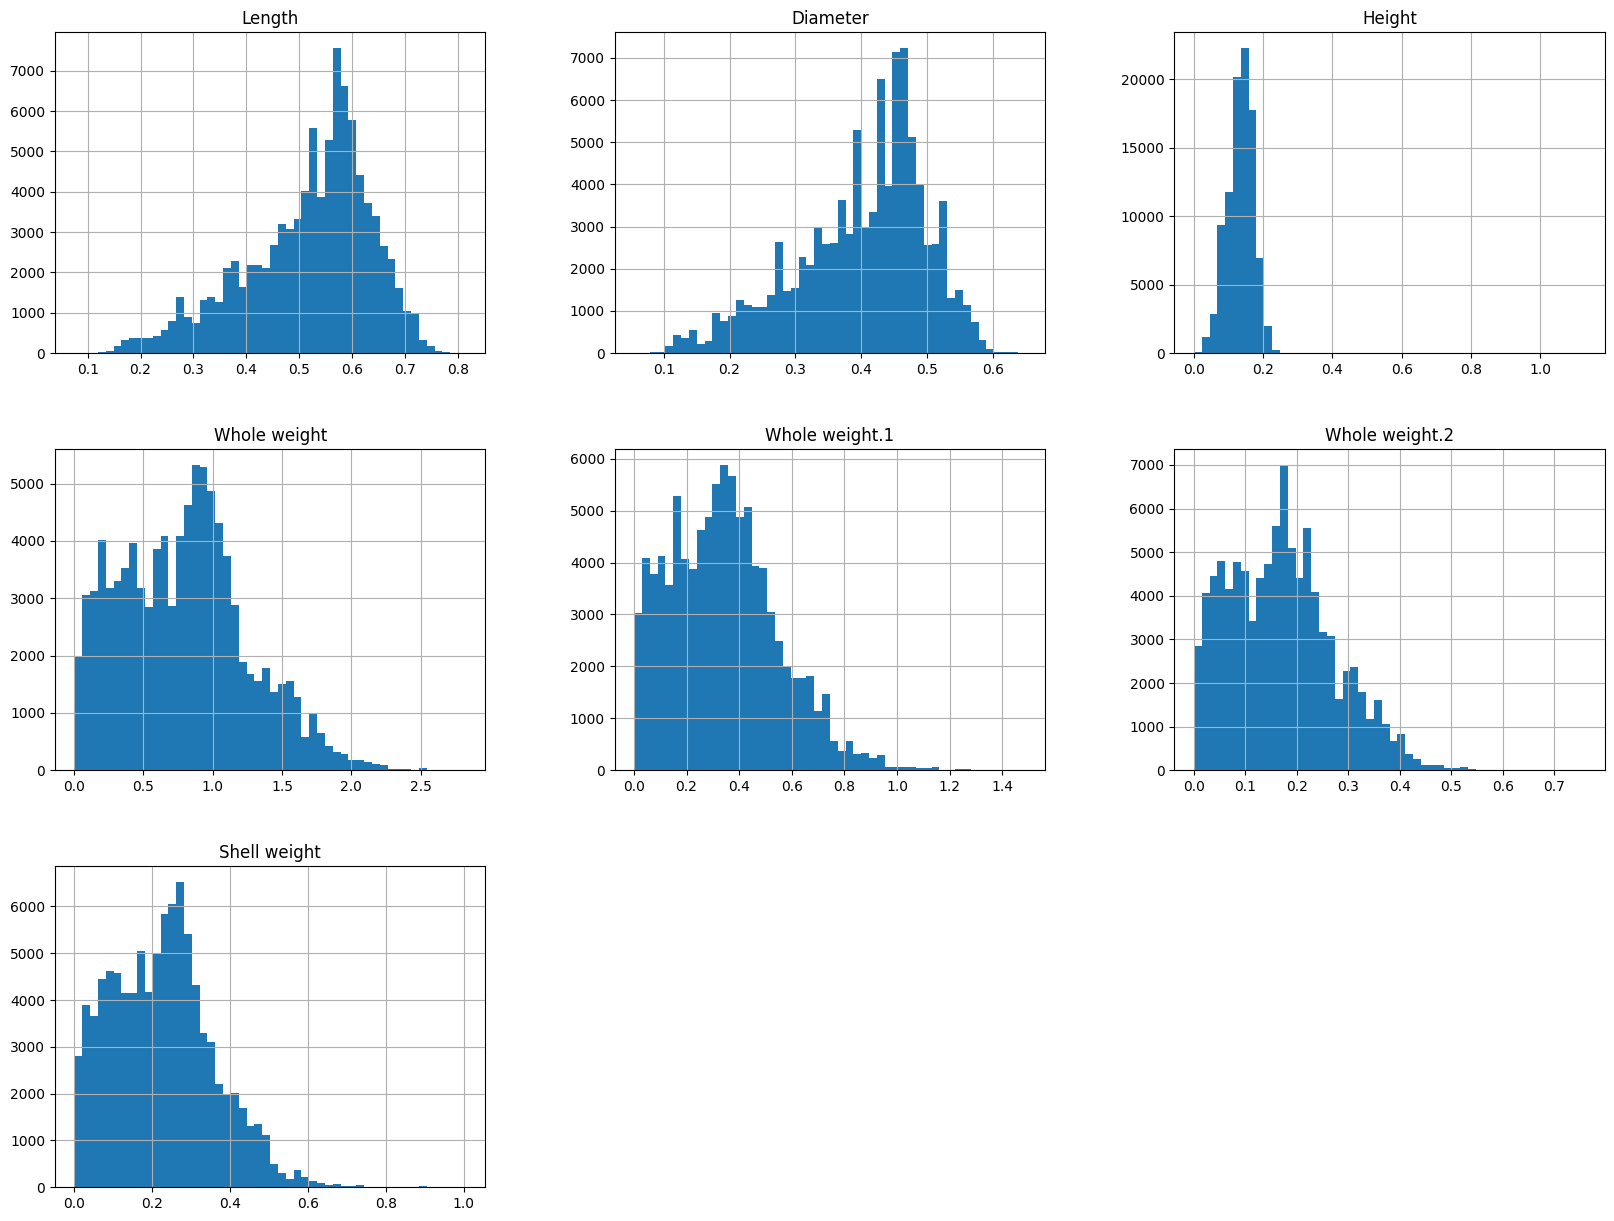

In [32]:
# plot histogram for each feature
X.hist(bins=50, figsize=(20,15))

<Axes: >

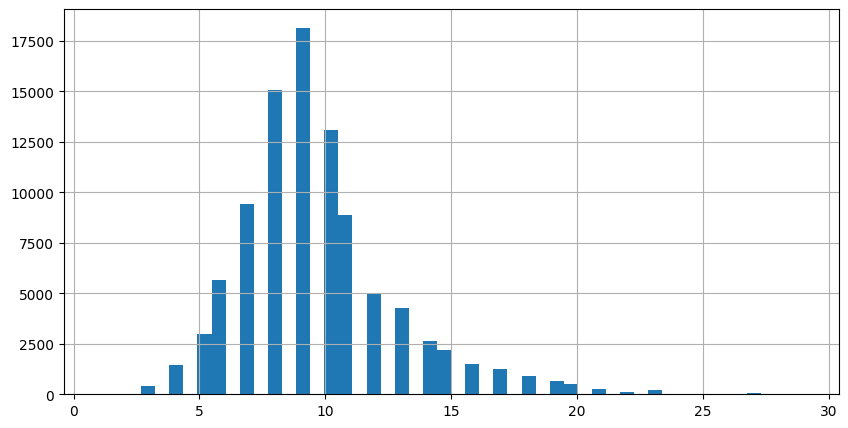

In [33]:
y.hist(bins=50, figsize=(10,5))

In [34]:
# count the frequency of categorical features 
X['Sex'].value_counts()


Sex
I    34435
M    32554
F    27802
Name: count, dtype: int64

## Feature Engineering

In [35]:
# # assuming the abalone is oval, we can calculate the area of the abalone 
# # the formula for the area of an oval is A = π * a * b
# new_X['Area'] = np.pi * new_X['Diameter'] * new_X['Length'] 
new_X_test = X_test.copy()
# new_X_test['Area'] = np.pi * new_X_test['Diameter'] * new_X_test['Length']


In [36]:
# one hot encoding for train and test 
# X = pd.get_dummies(X)
# X_test = pd.get_dummies(X_test)
# new_X = pd.get_dummies(new_X)
# new_X_test = pd.get_dummies(new_X_test)


# new_data = pd.read_csv('data/feature_reduced_new_train.csv', index_col='id')
# X = new_data.drop('Rings', axis=1)
# y = new_data['Rings']
# X_test = pd.read_csv('data/feature_test.csv', index_col='id')

X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

## Simple Regression Baselines

In [37]:
def rmsle(y_true, y_pred):
    # # parse the prediciton into int 
    # y_pred = np.round(y_pred)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)


In [38]:
# split the data into training and validation set
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# train a linear regression model 
# model = LinearRegression()
# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# RMSLE: 0.1651 (+/- 0.0060)
# RMSLE: 0.1656 (+/- 0.0109)


In [39]:
# train a Elastic Net model
from sklearn.linear_model import ElasticNet

# model = ElasticNet(alpha=0.1, l1_ratio=0.5)
# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# RMSLE: NA 
# RMSLE: 0.1685 (+/- 0.0050)

In [40]:
# train a random forest model 
from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_estimators=100, random_state=42) 
# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# RMSLE: 0.1547 (+/- 0.0053)
# RMSLE: 0.1533 (+/- 0.0053)

In [41]:
# train a gradient boosting model 
from sklearn.ensemble import GradientBoostingRegressor

# model = GradientBoostingRegressor(n_estimators=100, random_state=42)
# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# RMSLE: 0.1538 (+/- 0.0064)
# RMSLE: 0.1526 (+/- 0.0062)

In [42]:
# train a XGBoost model 
import xgboost as xgb

# model = xgb.XGBRegressor(n_estimators=100, random_state=42)
# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# RMSLE: 0.1507 (+/- 0.0059)
# RMSLE: 0.1494 (+/- 0.0058)

In [43]:
# train a LightGBM model 
import lightgbm as lgb

# model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# RMSLE: 0.1511 (+/- 0.0064)
# RMSLE: 0.1498 (+/- 0.0060)

In [44]:
# train a catboost model 
from catboost import CatBoostRegressor

# model = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# RMSLE: 0.1519 (+/- 0.0058)
# RMSLE: 0.1505 (+/- 0.0059)

In [45]:
# train a Bayesian Ridge model 
from sklearn.linear_model import BayesianRidge

# model = BayesianRidge()
# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# RMSLE: NA
# RMSLE: 0.1673 (+/- 0.0108)

In [46]:
# onehot encode new_X 
# new_X = pd.get_dummies(new_X)
# new_X_test = pd.get_dummies(new_X_test)
# scaler = StandardScaler()
# new_X_scaled = scaler.fit_transform(new_X)
# new_X_test_scaled = scaler.transform(new_X_test)

# model = xgb.XGBRegressor(n_estimators=100, random_state=42)
# # scores = cross_val_score(model, new_X_scaled, new_y, cv=10, scoring=rmsle_scorer)
# # print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

# model.fit(new_X_scaled, new_y)
# prediction = model.predict(new_X_test_scaled)
# submission = pd.DataFrame({'id': X_test.index, 'Rings': prediction})
# submission.to_csv('submissions/xgb2.csv', index=False)

In [47]:
# [I 2024-04-02 03:52:46,100] Trial 263 finished with value: 0.1493274514018394 
# and parameters: {'model': 'lightgbm', 'n_estimators': 360, 
# 'max_depth': 14, 'learning_rate': 0.02002177841890934, 
# 'subsample': 0.7312027119141618, 'colsample_bytree': 0.6574736218784601, 
# 'min_child_weight': 48, 'num_leaves': 180}. Best is trial 263 with value: 0.1493274514018394.

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_test_scaled = scaler.transform(X_test)

# scaler = StandardScaler()
# new_X_scaled = scaler.fit_transform(new_X)
# new_X_test_scaled = scaler.transform(new_X_test)

# model = lgb.LGBMRegressor(n_estimators=360, max_depth=14, learning_rate=0.02002177841890934, 
#                           subsample=0.7312027119141618, colsample_bytree=0.6574736218784601, 
#                           min_child_weight=48, num_leaves=180, random_state=42, verbose=-1)

# scores = cross_val_score(model, X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))
# print("===================================================================================")
# model = lgb.LGBMRegressor(n_estimators=360, max_depth=14, learning_rate=0.02002177841890934, 
#                           subsample=0.7312027119141618, colsample_bytree=0.6574736218784601, 
#                           min_child_weight=48, num_leaves=180, random_state=42, verbose=-1)

# scores = cross_val_score(model, new_X_scaled, y, cv=10, scoring=rmsle_scorer)
# print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

In [48]:
# # Best hyperparameters: {learning_rate=0.03910859789345321, n_estimators=646, max_depth=12, num_leaves=67, min_child_samples=74, subsample=0.566329687583204, colsample_bytree=0.7602133400888581}
# # Best hyperparameters: {learning_rate=0.02492276744603994, n_estimators=996, max_depth=8, min_child_weight=55, subsample=0.782986738013056, colsample_bytree=0.7416692551365455, reg_alpha=5.961291913968475e-08, 'reg_lambda': 2.8696931261494965}
# # Best hyperparameters: {learning_rate=0.11561172407978663, n_estimators=947, max_depth=7, l2_leaf_reg=18025801884692956=random_strength=3.235569246611154e-08, bootstrap_type='MVS'}

# new_data = pd.read_csv('data/reduced_new_train.csv', index_col='id')
# test = pd.read_csv('data/test.csv', index_col='id')

# X = new_data.drop('Rings', axis=1)
# y = new_data['Rings']
# X_test = test

# X = pd.get_dummies(X)
# X_test = pd.get_dummies(X_test)

# lgbmodel = lgb.LGBMRegressor(learning_rate=0.03910859789345321, 
#                           n_estimators=646, max_depth=12, num_leaves=67, 
#                           min_child_samples=74, subsample=0.566329687583204, 
#                           colsample_bytree=0.7602133400888581, verbose=-1)

# xgmodel = xgb.XGBRegressor(learning_rate=0.02492276744603994, 
#                           n_estimators=996, max_depth=8, min_child_weight=55, 
#                           subsample=0.782986738013056, colsample_bytree=0.7416692551365455, 
#                           reg_alpha=5.961291913968475e-08, reg_lambda=2.8696931261494965)

# catmodel = CatBoostRegressor(learning_rate=0.11561172407978663,
#                             n_estimators=947, max_depth=7, l2_leaf_reg=1.8025801884692956,
#                             random_strength=3.235569246611154e-08, bootstrap_type='MVS')

# lgbmodel.fit(X, y)
# xgmodel.fit(X, y)
# catmodel.fit(X, y)

# lgb_pred = lgbmodel.predict(X_test)
# xg_pred = xgmodel.predict(X_test)
# cat_pred = catmodel.predict(X_test)

# final_pred = (lgb_pred + xg_pred + cat_pred) / 3

# submission = pd.DataFrame({'id': X_test.index, 'Rings': final_pred})
# submission.to_csv('submissions/ensemble1.csv', index=False)

In [49]:
# train autogluon model

from autogluon.tabular import TabularPredictor

data = pd.read_csv("data/new_train.csv", index_col='id')
test = pd.read_csv("data/test.csv", index_col='id')
X = pd.get_dummies(data)
X_test = pd.get_dummies(test)

predictor = TabularPredictor(label='Rings').fit(X)
predictor.leaderboard()
predictions = predictor.predict(X_test)

submission = pd.DataFrame({'id': X_test.id, 'Rings': predictions})
submission.to_csv('submissions/autogluon2.csv', index=False)


No path specified. Models will be saved in: "AutogluonModels/ag-20240413_212905"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240413_212905"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct 5 21:02:42 UTC 2023
CPU Count:        

AttributeError: 'DataFrame' object has no attribute 'id'